# RNN Lab - Sentiment Classification

In [3]:
# importing relevant packages

import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download(["stopwords", "punkt", "wordnet"])
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from  tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional,LSTM,Dense,Embedding,Dropout, Conv1D,MaxPooling1D,GlobalAveragePooling1D, SimpleRNN,SpatialDropout1D 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import kerastuner as kt
from tensorflow import keras

import nlpaug.augmenter.word as naw


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sam_glass/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sam_glass/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/sam_glass/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading Data

In [4]:
data = pd.read_csv("../Lab_RNN/Data/emotions.csv") # creating data frame from the csv file

data.head()

,text,label
0,i feel so pissed off over an old friend and so...,anger
1,ive found it has made a huge difference especi...,anger
2,i also feel it is unfortunate that nearly all ...,sadness
3,i feel petty a href http clairee,anger
4,i used to believe that a feeling like fear was...,sadness


In [5]:
data.value_counts # using value count to count how many rows in data frame

<bound method DataFrame.value_counts of                                                     text    label
0      i feel so pissed off over an old friend and so...    anger
1      ive found it has made a huge difference especi...    anger
2      i also feel it is unfortunate that nearly all ...  sadness
3                       i feel petty a href http clairee    anger
4      i used to believe that a feeling like fear was...  sadness
...                                                  ...      ...
19995  i was i might be buying stuff from there but i...      joy
19996  i like sonam deepika and genelia who i feel ar...      joy
19997  i feel pathetic that i can hardly go a whole d...  sadness
19998  id have spent more time with her on reading i ...  sadness
19999  i do however feel like one of those pathetic g...  sadness

[20000 rows x 2 columns]>

The data set contains 20000 rows of data, with 2 columns. We can see that the label column contains some categorical data. I will explore how many categories there is.

In [6]:
# checking if any nan values are present in the dataset
data.isnull().sum()

text     0
label    0
dtype: int64

In [7]:
# Checking for any duplicates within the data set
duplicates =data[data.duplicated]
print(f"Duplicates {duplicates}")

Duplicates                                                    text label
6154  i feel more adventurous willing to take risks ...   joy


In [8]:
# remove duplicates in dataset
data = data.drop_duplicates()

In [9]:
# Checking again for any duplicates within the data set
duplicates =data[data.duplicated]
print(f"Duplicates {duplicates}")

Duplicates Empty DataFrame
Columns: [text, label]
Index: []


I will now look over the categories to see how the data is distributed. 

<Axes: xlabel='label'>

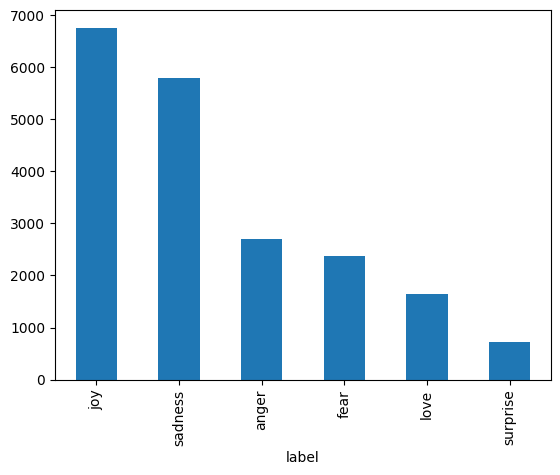

In [10]:
data.label.value_counts().plot.bar() 

The data set is not very balanced. There are many data points that are in the joy and sadness category. The other four categories have less then half of the other two categories. I will train on this data to begin with but will see if I have to augment the data afterwards to see if it will improve the bias of the model.  

### Preprocessing the text 

I will now pre process the data set so that it is ready for an RNN model. 
Different processes will be used and I will explain them during the cleaning.

#### This removes any punctionation that may occur in both the text and label

In [11]:
# Removing any puntionation within the data set
data.loc[:, "text"] = data["text"].str.replace('[\[\]"\']','') 
data.loc[:, "label"] = data["label"].str.replace('[^\w\s"\'\[\]]','')

The next process is converting any text to lower case, removing stop words and lemmatizing the text.

- stop words are words that are common within the language. For example (The, I, and) plus many more. I have used the nltk package which has a library of stop words that are common within the english language. This will filter out any words that occur iin that list.

- Lemmatizing is when you take a word to its root form. For exampling if you had running as a word it would be changes to run. This groups words that have a common relation together.

In [12]:
# create a pre processing function that will process the text column

def preprocess_text(text):
    
    # convert text to lowercase
    text = text.lower()

    #Remove stop words

    stop_words = set(stopwords.words("english"))
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the tokens

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    processed_text = " ".join(lemmatized_tokens)

    return processed_text

In [13]:
data.loc[:, "text"] = data["text"].apply(preprocess_text)
data.head()

,text,label
0,feel pissed old friend friend,anger
1,ive found made huge difference especially fing...,anger
2,also feel unfortunate nearly reader going meet...,sadness
3,feel petty href http clairee,anger
4,used believe feeling like fear ignored suppres...,sadness


Now the data has been cleaned I will check how many words are contained within the rows of the text column. This is good practice as the next step in the processing is to tokenize and pad the text so that it is in numerical format for the model to learn from. 

In [14]:
# checking the length of the strings so that i have an idea of how long i should make the max words in the sequence length for padding
print(pd.Series(data["text"]).str.len().mean()) # mean number of words in a sentence
print( pd.Series(data["text"]).str.len().max()) # longest sentence in the data set

60.805790289514476
229


This box plot will give an idea of how the long sentence lengths are within the data set and the amounts

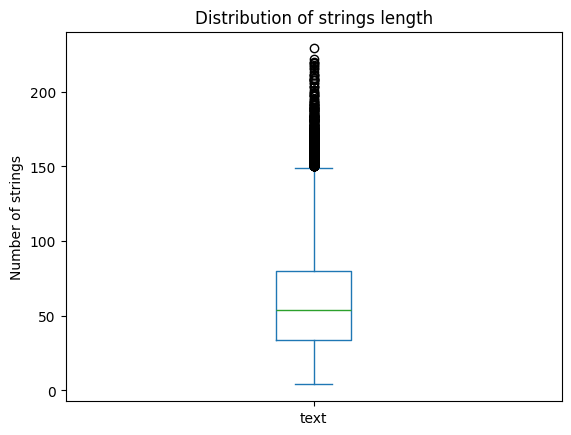

count    19999.000000
mean        60.805790
std         34.519413
min          4.000000
25%         34.000000
50%         54.000000
75%         80.000000
max        229.000000
Name: text, dtype: float64

In [15]:
strings_len = pd.Series(data["text"]).str.len()

strings_len.plot.box()
plt.title("Distribution of strings length")
plt.ylabel("Number of strings")
plt.show()

strings_len.describe()

You can see most strings are up to 150 words. But with using the describe function on the length of the strings we can see that around 75 % of the comments are up to 80 words long.
The box plot also shows that most sentences are between 40 and 80. This will be taken into account when padding. Some sentences may be shorter so they will need to have padding. This is an important stage as we need to decide how many relevant words of the text should be processed within the model. If we use too many the training process will be longer. We can see on the box plot that most of the text lengths are between the 40 to 100 range. So I think it is reasonable to have the input length at 80.

After trying my first model designs, the model was not learning. After some exploration from my teacher, we discovered that the issue was the sentence length was too long. The effects of over padding were present and this seemed to have an effect on the models learning Therefore I will change my sentence length to 50. This will hopefully give the model enough text to learn from.

#### Preparing text to be used with Deep learning model

I will now tokenize the text and pad it. I will also one hot encode the labels. This ensures that the data is in numerical format. This is better as the model finds it easier to predict with numbers instead of letters. 

The data will then also be split into training, validation and test sets. This is so that the model trains on not the full data set. Then its performance can be testes on the test set and the validation is to validate the accuracy of the model during training. 



In [16]:
# encoding emotions
encoded_emotions = {
    "anger" : 0,
    "fear": 1,
    "joy" : 2,
    "love": 3,
    "sadness": 4,
    "surprise": 5
}

data.replace(encoded_emotions, inplace = True)
data.head()

/tmp/ipykernel_980/2507044824.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.replace(encoded_emotions, inplace = True)


,text,label
0,feel pissed old friend friend,0
1,ive found made huge difference especially fing...,0
2,also feel unfortunate nearly reader going meet...,4
3,feel petty href http clairee,0
4,used believe feeling like fear ignored suppres...,4


In [17]:
# Splitting the data into train, val and test before toeknization and padding
def split_data(data):   
    X_train, X_test, y_train, y_test = train_test_split(data["text"], data["label"], test_size=0.2, random_state=42, stratify=data["label"])

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

    print(f"X_train = {X_train.shape} and y_train = {y_train.shape}")
    print(f"X_test = {X_test.shape} and y_test = {y_test.shape}")
    print(f"X_val = {X_val.shape} and y_val = {y_val.shape}")

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot for y_train
    axs[0].bar(y_train.value_counts().index, y_train.value_counts())
    axs[0].set_title('y_train')
    axs[0].set_ylabel('Count')

    # Plot for y_val
    axs[1].bar(y_val.value_counts().index, y_val.value_counts())
    axs[1].set_title('y_val')
    axs[1].set_ylabel('Count')

    # Plot for y_test
    axs[2].bar(y_test.value_counts().index, y_test.value_counts())
    axs[2].set_title('y_test')
    axs[2].set_ylabel('Count')

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()

    return X_train, X_test, X_val, y_train, y_val, y_test

    

X_train = (11999,) and y_train = (11999,)
X_test = (4000,) and y_test = (4000,)
X_val = (4000,) and y_val = (4000,)


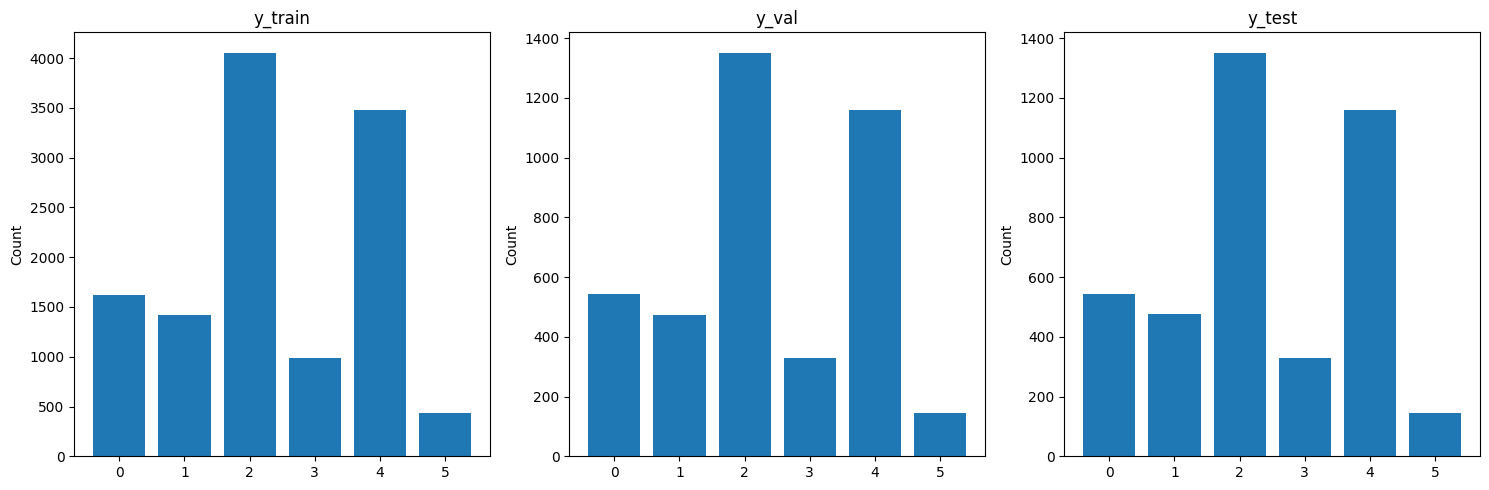

In [18]:
X_train, X_test, X_val, y_train, y_val, y_test = _ = split_data(data)

In [19]:
X_train

12266    feel like probably would liked book little bit...
19269    didnt feel stupid still little bit ignorant co...
4670                             feel like useless bastard
4986     feel weird scattered wonder million different ...
18718               feel like damaged good deserves better
                               ...                        
857                         feeling like pretty crappy mom
17030                          help daughter feeling angry
18329    also feel ungrateful hearing story grandma peo...
9625     felt really bad claudia always amazing time la...
16631                        go pt feel like defective bum
Name: text, Length: 11999, dtype: object

In [20]:
y_train

12266    3
19269    4
4670     4
4986     5
18718    4
        ..
857      4
17030    0
18329    4
9625     4
16631    4
Name: label, Length: 11999, dtype: int64

Now that the labels have been one hot encoded and the data split I will tokenize the text. 

Tokenizing is where every word within the sentence is assigned a number. If the word occurs more than once it will have the same number that it was assigned during the tokenization. 

for example "feel pissed old friend friend" would be represented as "1, 2, 3, 4, 4" 

In [21]:
    # Tokenize the text data
def tokenizer_padding(X_train, X_val, X_test,max_words, max_length):
        
        tokenizer = Tokenizer(num_words=max_words)
        tokenizer.fit_on_texts(X_train.astype(str))

        X_train_seq = tokenizer.texts_to_sequences(X_train.astype(str))
        X_val_seq = tokenizer.texts_to_sequences(X_val.astype(str))
        X_test_seq = tokenizer.texts_to_sequences(X_test.astype(str))


        vocab_size = len(tokenizer.word_index) + 1
        print(vocab_size)
        print(tokenizer.word_index)

        for i in range (5):
            print(f"Sequence {i + 1}: {X_train_seq[i]}")


        max_sequence_length = max_length

        X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding="post")
        X_val_padded = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding="post")
        X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding="post")

        for i in range (3):
            print(f"Sequence{i +1}: {X_train_padded[i]}")   

        return X_train_padded, X_val_padded, X_test_padded

In [22]:
X_train, X_val, X_test = tokenizer_padding(X_train, X_val, X_test, 19999, 50)

11662
{'feel': 1, 'feeling': 2, 'like': 3, 'im': 4, 'time': 5, 'really': 6, 'know': 7, 'make': 8, 'get': 9, 'little': 10, 'want': 11, 'day': 12, 'people': 13, 'thing': 14, 'one': 15, 'would': 16, 'still': 17, 'think': 18, 'life': 19, 'ive': 20, 'even': 21, 'bit': 22, 'way': 23, 'going': 24, 'love': 25, 'something': 26, 'much': 27, 'dont': 28, 'could': 29, 'need': 30, 'go': 31, 'good': 32, 'pretty': 33, 'back': 34, 'right': 35, 'say': 36, 'today': 37, 'always': 38, 'see': 39, 'also': 40, 'made': 41, 'work': 42, 'around': 43, 'though': 44, 'friend': 45, 'cant': 46, 'year': 47, 'help': 48, 'got': 49, 'didnt': 50, 'well': 51, 'come': 52, 'felt': 53, 'sure': 54, 'thought': 55, 'someone': 56, 'every': 57, 'le': 58, 'never': 59, 'week': 60, 'take': 61, 'lot': 62, 'look': 63, 'many': 64, 'happy': 65, 'away': 66, 'home': 67, 'find': 68, 'kind': 69, 'anything': 70, 'without': 71, 'quite': 72, 'everything': 73, 'better': 74, 'person': 75, 'ever': 76, 'enough': 77, 'http': 78, 'last': 79, 'getting

## Model Design

I will now design a model. I will use the Long Short-Term Memory(LSTM) type of RNN model as it handles stochastic gradient failure better than a regular RNN. It can handle longer sequences better. I will start by creating a simple network with one LTSM layer to see how the  model performs.

I will use the following formula to determine the number of nodes within the layer: 

$ N_i = \frac{2}{3} * (N_i + N_o) $

$N_i$ is equal to the number of input words
$N_o$ is equal to number of output neurons

This will give me a basic idea on what number of nodes to begin with then I can adjust after training the model. 

I will also include a Dropout layer to help reduce in overfitting. This will randomly ignore selected neurons during training and reduce the sensitivity of specific weights. I have chosen 0.2 as my starting point as it is a good compromise in retaining accuracy and overfitting.

I will use the softmax activation function in my activation layer as it will interpret the outputs as probabilities for each class.

The model I will build will be simple to begin then it will be built upon by testing different hyperparemters with the keras tuner

In [23]:
hidden_nodes = int(2/3 * (60 * 6))
print(f"The number of hidden nodes is: {hidden_nodes}")

The number of hidden nodes is: 240


In [24]:
def train_and_evaluate_model(X_train, X_test, X_val, y_train, y_test, y_val, epochs, checkpoint_filepath, max_tokens, input_length):
    
    model= Sequential()
    model.add(Embedding(max_tokens, 64, input_length=input_length))
    model.add(LSTM(10,return_sequences=True))
    model.add(LSTM(10,return_sequences=False))
    #model.add(LSTM(10, dropout=0.2, return_sequences=True))
    #model.add(LSTM(10, dropout=0.2, return_sequences=False))
    model.add(Dense(240, activation="relu")) 
    model.add(Dense(6, activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=3)
    
    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath, 
        monitor="val_accuracy", 
        mode="max", verbose=1, 
        save_best_only=True

    )

    history = model.fit(X_train, y_train, 
                        validation_data=(X_val,y_val), 
                        epochs=epochs,batch_size=64, 
                        callbacks=[early_stopping, model_checkpoint]) 

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0) # test data results when run through the model
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    #visualizing training and validation results
    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss ")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    print(model.summary())

    best_model = load_model(checkpoint_filepath)
    
    return best_model


Epoch 1/50
188/188 [==============================] - ETA: 0s - loss: 1.5989 - accuracy: 0.3246
Epoch 1: val_accuracy improved from -inf to 0.33800, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 32s 148ms/step - loss: 1.5989 - accuracy: 0.3246 - val_loss: 1.5743 - val_accuracy: 0.3380
Epoch 2/50
188/188 [==============================] - ETA: 0s - loss: 1.5760 - accuracy: 0.3380
Epoch 2: val_accuracy did not improve from 0.33800
188/188 [==============================] - 15s 80ms/step - loss: 1.5760 - accuracy: 0.3380 - val_loss: 1.5765 - val_accuracy: 0.3380
Epoch 3/50
188/188 [==============================] - ETA: 0s - loss: 1.5753 - accuracy: 0.3350
Epoch 3: val_accuracy did not improve from 0.33800
188/188 [==============================] - 17s 91ms/step - loss: 1.5753 - accuracy: 0.3350 - val_loss: 1.5774 - val_accuracy: 0.3380
Epoch 4/50
188/188 [==============================] - ETA: 0s - loss: 1.3939 - accuracy: 0.3797
Epoch 4: val_accuracy improved from 0.33800 to 0.43075, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 20s 105ms/step - loss: 1.3939 - accuracy: 0.3797 - val_loss: 1.2518 - val_accuracy: 0.4308
Epoch 5/50
188/188 [==============================] - ETA: 0s - loss: 1.2476 - accuracy: 0.4094
Epoch 5: val_accuracy did not improve from 0.43075
188/188 [==============================] - 15s 78ms/step - loss: 1.2476 - accuracy: 0.4094 - val_loss: 1.3235 - val_accuracy: 0.3905
Epoch 6/50
188/188 [==============================] - ETA: 0s - loss: 1.2970 - accuracy: 0.4082
Epoch 6: val_accuracy did not improve from 0.43075
188/188 [==============================] - 15s 81ms/step - loss: 1.2970 - accuracy: 0.4082 - val_loss: 1.5789 - val_accuracy: 0.3380
Epoch 7/50
188/188 [==============================] - ETA: 0s - loss: 1.3489 - accuracy: 0.3974
Epoch 7: val_accuracy did not improve from 0.43075
188/188 [==============================] - 13s 72ms/step - loss: 1.3489 - accuracy: 0.3974 - val_loss: 1.2747 - val_accuracy: 0.4308
Epoch 7: early stopping
Te

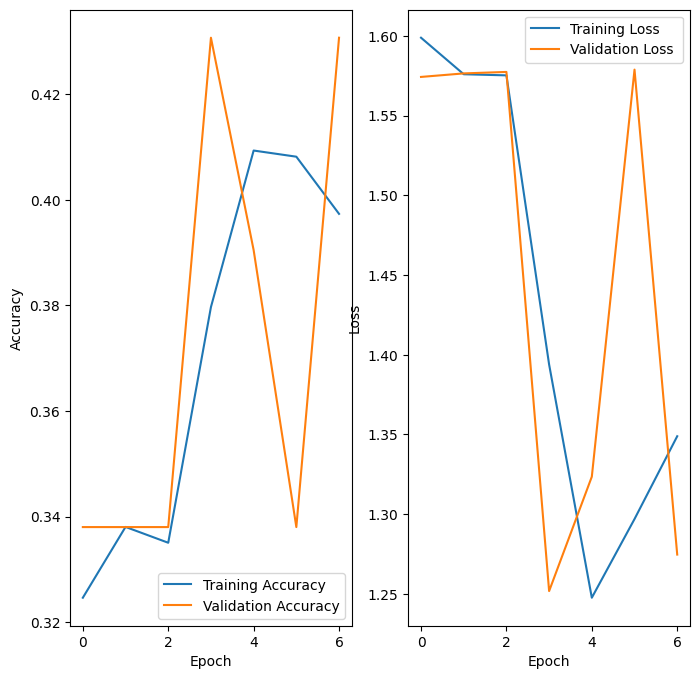

In [25]:
train_and_evaluate_model(X_train, X_test, X_val, y_train, y_test, y_val,50, "../Lab_RNN/model_save",11662, 50)


In [26]:
def train_and_evaluate_model(X_train, X_test, X_val, y_train, y_test, y_val, epochs, checkpoint_filepath, max_tokens, input_length):
    
    model= Sequential()
    model.add(Embedding(max_tokens, 64, input_length=input_length))
    model.add(LSTM(10,dropout=0.2,return_sequences=True))
    model.add(LSTM(10,dropout=0.2,return_sequences=True))
    model.add(LSTM(10, dropout=0.2, return_sequences=True))
    model.add(LSTM(10, dropout=0.2, return_sequences=False))
    model.add(Dropout(rate=0.2))
    model.add(Dense(240, activation="relu"))
    model.add(Dense(120, activation= "relu"))
    model.add(Dense(50, activation= "relu"))
    model.add(Dense(6, activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=3)
    
    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath, 
        monitor="val_accuracy", 
        mode="max", verbose=1, 
        save_best_only=True

    )

    history = model.fit(X_train, y_train, 
                        validation_data=(X_val,y_val), 
                        epochs=epochs,batch_size=64, 
                        callbacks=[early_stopping, model_checkpoint]) 

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0) # test data results when run through the model
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    #visualizing training and validation results
    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss ")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    print(model.summary())

    best_model = load_model(checkpoint_filepath)
    
    return best_model


Epoch 1/50
188/188 [==============================] - ETA: 0s - loss: 1.5941 - accuracy: 0.3326
Epoch 1: val_accuracy improved from -inf to 0.33800, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 52s 236ms/step - loss: 1.5941 - accuracy: 0.3326 - val_loss: 1.5748 - val_accuracy: 0.3380
Epoch 2/50
188/188 [==============================] - ETA: 0s - loss: 1.4211 - accuracy: 0.3691
Epoch 2: val_accuracy improved from 0.33800 to 0.42600, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 41s 221ms/step - loss: 1.4211 - accuracy: 0.3691 - val_loss: 1.2374 - val_accuracy: 0.4260
Epoch 3/50
188/188 [==============================] - ETA: 0s - loss: 1.1101 - accuracy: 0.4408
Epoch 3: val_accuracy improved from 0.42600 to 0.43525, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 41s 216ms/step - loss: 1.1101 - accuracy: 0.4408 - val_loss: 1.1501 - val_accuracy: 0.4353
Epoch 4/50
188/188 [==============================] - ETA: 0s - loss: 1.0164 - accuracy: 0.4669
Epoch 4: val_accuracy improved from 0.43525 to 0.44100, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 40s 214ms/step - loss: 1.0164 - accuracy: 0.4669 - val_loss: 1.1303 - val_accuracy: 0.4410
Epoch 5/50
188/188 [==============================] - ETA: 0s - loss: 0.9236 - accuracy: 0.5253
Epoch 5: val_accuracy improved from 0.44100 to 0.48475, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 36s 189ms/step - loss: 0.9236 - accuracy: 0.5253 - val_loss: 1.1233 - val_accuracy: 0.4848
Epoch 6/50
188/188 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.6751
Epoch 6: val_accuracy improved from 0.48475 to 0.66000, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 43s 227ms/step - loss: 0.7411 - accuracy: 0.6751 - val_loss: 0.9236 - val_accuracy: 0.6600
Epoch 7/50
188/188 [==============================] - ETA: 0s - loss: 0.5658 - accuracy: 0.7666
Epoch 7: val_accuracy improved from 0.66000 to 0.70000, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 39s 207ms/step - loss: 0.5658 - accuracy: 0.7666 - val_loss: 0.8605 - val_accuracy: 0.7000
Epoch 8/50
188/188 [==============================] - ETA: 0s - loss: 0.4869 - accuracy: 0.7900
Epoch 8: val_accuracy improved from 0.70000 to 0.72100, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 36s 194ms/step - loss: 0.4869 - accuracy: 0.7900 - val_loss: 0.9300 - val_accuracy: 0.7210
Epoch 9/50
188/188 [==============================] - ETA: 0s - loss: 0.4453 - accuracy: 0.8117
Epoch 9: val_accuracy improved from 0.72100 to 0.73725, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 38s 202ms/step - loss: 0.4453 - accuracy: 0.8117 - val_loss: 0.7898 - val_accuracy: 0.7372
Epoch 10/50
188/188 [==============================] - ETA: 0s - loss: 0.3986 - accuracy: 0.8238
Epoch 10: val_accuracy did not improve from 0.73725
188/188 [==============================] - 25s 132ms/step - loss: 0.3986 - accuracy: 0.8238 - val_loss: 0.8226 - val_accuracy: 0.7300
Epoch 11/50
188/188 [==============================] - ETA: 0s - loss: 0.3695 - accuracy: 0.8349
Epoch 11: val_accuracy improved from 0.73725 to 0.76475, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 37s 196ms/step - loss: 0.3695 - accuracy: 0.8349 - val_loss: 0.7342 - val_accuracy: 0.7648
Epoch 12/50
188/188 [==============================] - ETA: 0s - loss: 0.3515 - accuracy: 0.8425
Epoch 12: val_accuracy improved from 0.76475 to 0.77250, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 36s 193ms/step - loss: 0.3515 - accuracy: 0.8425 - val_loss: 0.7181 - val_accuracy: 0.7725
Epoch 13/50
188/188 [==============================] - ETA: 0s - loss: 0.3141 - accuracy: 0.8543
Epoch 13: val_accuracy did not improve from 0.77250
188/188 [==============================] - 26s 137ms/step - loss: 0.3141 - accuracy: 0.8543 - val_loss: 0.6685 - val_accuracy: 0.7710
Epoch 14/50
188/188 [==============================] - ETA: 0s - loss: 0.2940 - accuracy: 0.8705
Epoch 14: val_accuracy improved from 0.77250 to 0.79950, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 38s 202ms/step - loss: 0.2940 - accuracy: 0.8705 - val_loss: 0.7517 - val_accuracy: 0.7995
Epoch 15/50
188/188 [==============================] - ETA: 0s - loss: 0.2477 - accuracy: 0.9111
Epoch 15: val_accuracy improved from 0.79950 to 0.84225, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 44s 236ms/step - loss: 0.2477 - accuracy: 0.9111 - val_loss: 0.6478 - val_accuracy: 0.8422
Epoch 16/50
188/188 [==============================] - ETA: 0s - loss: 0.2356 - accuracy: 0.9272
Epoch 16: val_accuracy did not improve from 0.84225
188/188 [==============================] - 25s 133ms/step - loss: 0.2356 - accuracy: 0.9272 - val_loss: 0.5841 - val_accuracy: 0.8400
Epoch 17/50
188/188 [==============================] - ETA: 0s - loss: 0.1794 - accuracy: 0.9524
Epoch 17: val_accuracy improved from 0.84225 to 0.86050, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 38s 200ms/step - loss: 0.1794 - accuracy: 0.9524 - val_loss: 0.5886 - val_accuracy: 0.8605
Epoch 18/50
188/188 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.9595
Epoch 18: val_accuracy improved from 0.86050 to 0.86125, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


188/188 [==============================] - 39s 206ms/step - loss: 0.1586 - accuracy: 0.9595 - val_loss: 0.6047 - val_accuracy: 0.8612
Epoch 19/50
188/188 [==============================] - ETA: 0s - loss: 0.1361 - accuracy: 0.9664
Epoch 19: val_accuracy did not improve from 0.86125
188/188 [==============================] - 30s 160ms/step - loss: 0.1361 - accuracy: 0.9664 - val_loss: 0.5871 - val_accuracy: 0.8608
Epoch 19: early stopping
Test Loss: 0.5986, Test Accuracy: 0.8585
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 64)            746368    
                                                                 
 lstm_2 (LSTM)               (None, 50, 10)            3000      
                                                                 
 lstm_3 (LSTM)               (None, 50, 10)            840       
                                 

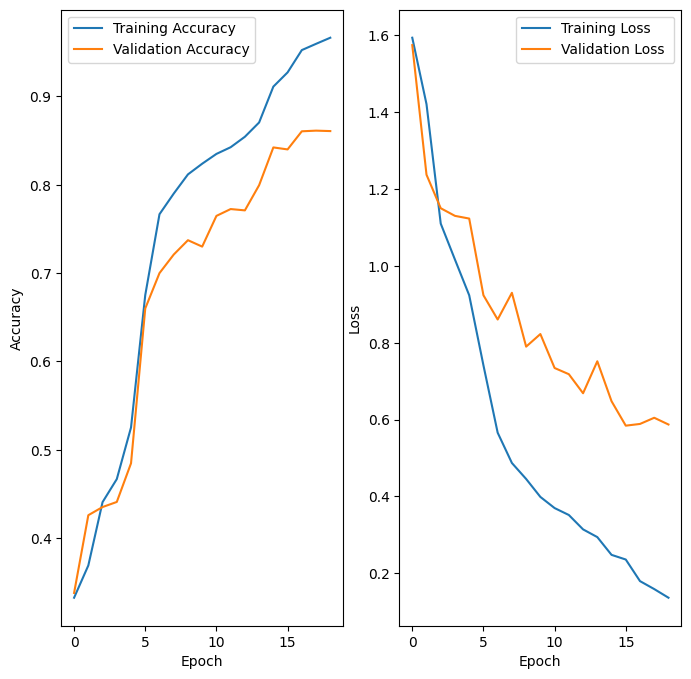

In [27]:
train_and_evaluate_model(X_train, X_test, X_val, y_train, y_test, y_val,50, "../Lab_RNN/model_save",11662, 50)


This model seems to be working much better

In [28]:
def model_builder(hp):
    model= Sequential()
    model.add(Embedding(11662, 64, input_length=50))
    model.add(LSTM(units= hp.Choice("LSTM_units", values= [5,10, 15, 20]),
                   dropout=hp.Choice("LTSM_dropout", values=[0.2,0.3, 0.4,0.5]),
                   return_sequences=True))
    model.add(LSTM(units= hp.Choice("LSTM_units", values= [5,10, 15, 20]),
                   dropout=hp.Choice("LTSM_dropout", values=[0.2,0.3, 0.4,0.5]),
                   return_sequences=True))
    model.add(LSTM(units= hp.Choice("LSTM_units", values= [5,10, 15, 20]),
                   dropout=hp.Choice("LTSM_dropout", values=[0.2,0.3, 0.4,0.5]),
                   return_sequences=True))
    model.add(LSTM(units= hp.Choice("LSTM_units", values= [5,10, 15, 20]),
                   dropout=hp.Choice("LTSM_dropout", values=[0.2,0.3, 0.4,0.5]),
                   return_sequences=False))
    model.add(Dropout(rate=hp.Choice("dropout", values=[0.2,0.3,0.4,0.5])))
    model.add(Dense(units=hp.Int("Dense_units",min_value = 64, max_value=240, step=64),
                    activation="relu"))
    model.add(Dense(units=hp.Int("Dense_units",min_value = 10, max_value=250, step=25),
                    activation="relu"))
    model.add(Dense(units=hp.Int("Dense_units",min_value = 10, max_value=250, step=25),
                    activation="relu"))
    model.add(Dense(units=hp.Int("Dense_units",min_value = 10, max_value=250, step=25),
                    activation="relu"))
    model.add(Dense(6, activation="softmax"))

    model.compile(
    optimizer=Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

    return model

In [29]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy', # which parameter to observe
                     max_epochs=10,
                     factor=3, #the reduction factor, The smaller it is the more aggressive reduction in configurations
                     directory='tuner_results_RNN', # results saved to a directory
                     project_name='sentiment')

Reloading Tuner from tuner_results_RNN/sentiment/tuner0.json


In [30]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3) # early stopping used when better parameters are found to save time in tuning


In [31]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping]) # The training search

In [32]:
best_model = tuner.get_best_models(num_models=1)
print(best_model[0].summary())

# prints out best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 64)            746368    
                                                                 
 lstm (LSTM)                 (None, 50, 15)            4800      
                                                                 
 lstm_1 (LSTM)               (None, 50, 15)            1860      
                                                                 
 lstm_2 (LSTM)               (None, 50, 15)            1860      
                                                                 
 lstm_3 (LSTM)               (None, 15)                1860      
                                                                 
 dropout (Dropout)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 192)               3

In [33]:
tuner.results_summary()

Results summary
Results in tuner_results_RNN/sentiment
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0016 summary
Hyperparameters:
LSTM_units: 15
LTSM_dropout: 0.2
dropout: 0.3
Dense_units: 192
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.8512499928474426

Trial 0024 summary
Hyperparameters:
LSTM_units: 20
LTSM_dropout: 0.3
dropout: 0.4
Dense_units: 64
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.7947499752044678

Trial 0017 summary
Hyperparameters:
LSTM_units: 20
LTSM_dropout: 0.5
dropout: 0.5
Dense_units: 128
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 0.7717499732971191

Trial 0012 summary
Hyperparameters:
LSTM_units: 15
LTSM_dropout: 0.2
dropout: 0.3
Dense_units: 192
learning_rate: 0.001
tuner/epochs: 4
tuner/initial_epoc

In [34]:
best_hypermodel = tuner.hypermodel.build(best_hyperparameters)


early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=3)

history_1 = best_hypermodel.fit(X_train, y_train, 
                    validation_data=(X_val,y_val), 
                    epochs=50,batch_size=64, 
                    callbacks=[early_stopping]) 

test_loss, test_accuracy = best_hypermodel.evaluate(X_test, y_test, verbose=0) # test data results when run through the model
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

#visualizing training and validation results
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(history_1.history["accuracy"], label="Training Accuracy")
plt.plot(history_1.history_1["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


Epoch 1/50
188/188 [==============================] - 37s 150ms/step - loss: 1.5927 - accuracy: 0.3337 - val_loss: 1.5778 - val_accuracy: 0.3380
Epoch 2/50
188/188 [==============================] - 28s 147ms/step - loss: 1.5768 - accuracy: 0.3314 - val_loss: 1.5787 - val_accuracy: 0.3380
Epoch 3/50
188/188 [==============================] - 29s 152ms/step - loss: 1.5770 - accuracy: 0.3358 - val_loss: 1.5761 - val_accuracy: 0.3380
Epoch 4/50
188/188 [==============================] - 27s 143ms/step - loss: 1.3719 - accuracy: 0.3816 - val_loss: 1.2468 - val_accuracy: 0.4205
Epoch 5/50
188/188 [==============================] - 27s 144ms/step - loss: 1.0850 - accuracy: 0.4417 - val_loss: 1.1040 - val_accuracy: 0.4383
Epoch 6/50
188/188 [==============================] - 28s 146ms/step - loss: 0.9137 - accuracy: 0.5045 - val_loss: 1.0681 - val_accuracy: 0.4823
Epoch 7/50
188/188 [==============================] - 27s 144ms/step - loss: 0.8349 - accuracy: 0.5208 - val_loss: 1.0119 - val_ac

AttributeError: 'list' object has no attribute 'evaluate'